### 1. 数据预处理

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import h5py
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.models import load_model
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

%matplotlib inline

Using TensorFlow backend.


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
!ls ./

kaggle-dog-breeds.ipynb  labels.csv		test
keras-pretrained-models  sample_submission.csv	train


#### 1.1 训练/测试集图片的id，以及训练集对应的labels，提交样本是多分类，每一类都有其概率

In [5]:
INPUT_SIZE = 224
NUM_CLASSES = 16
SEED = 1987
base_dir = "./"
# train data
train_id = os.listdir(os.path.join(base_dir, 'train')) # list
#train data labels
labels = pd.read_csv(os.path.join(base_dir, 'labels.csv'))  # DataFrame
#test 
test_id = os.listdir(os.path.join(base_dir, 'test'))
# sample submission
sample_submission = pd.read_csv(os.path.join(base_dir, 'sample_submission.csv'))
print(len(train_id), labels.shape)
print(len(test_id), sample_submission.shape)

10222 (10222, 2)
10357 (10357, 121)


#### 1.2 在没有GPU的情况下先只是用样本数量最多的16类
使用pandas进行预处理

#### 1.2.1 按照breed分组
将对象pandas.core.groupby.DataFrameGroupBy转换为list即可显示出来

In [6]:
labels_group = labels.groupby('breed')
labels_group_list = [x for x in labels_group]  # 120 classes
print(len(labels_group_list))
print(labels_group_list[0][0]) # tuple
print(labels_group_list[0][1].head(5))  # dataFrame

120
affenpinscher
                                   id          breed
30   00ca18751837cd6a22813f8e221f7819  affenpinscher
44   01268f0007876a692907bda89468184c  affenpinscher
56   0162107acd8f2588c0944b791d61bb0c  affenpinscher
172  040fef64640b89c53f161b6c5215b78b  affenpinscher
194  0484a6cc686a07e1edacd0fb44b1d965  affenpinscher


In [7]:
selected_breed_list = labels_group.count()
print(selected_breed_list.head(5))

                                 id
breed                              
affenpinscher                    80
afghan_hound                    116
african_hunting_dog              86
airedale                        107
american_staffordshire_terrier   74


In [8]:
selected_breed_list = selected_breed_list.sort_values(by='id',ascending=False).head(NUM_CLASSES).index
selected_breed_list = list(selected_breed_list)
print(selected_breed_list)

['scottish_deerhound', 'maltese_dog', 'afghan_hound', 'entlebucher', 'bernese_mountain_dog', 'shih-tzu', 'great_pyrenees', 'pomeranian', 'basenji', 'samoyed', 'airedale', 'tibetan_terrier', 'leonberg', 'cairn', 'beagle', 'japanese_spaniel']


#### 1.2.2 获取前16类的原始数据

这样写时会出现这样的错误 SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead，

```python
labels['rank'] = labels.groupby('breed').rank()['id']
```
修改为下面这样就可以了：
```python
labels['rank'] = labels_group.rank()['id']
```
参考：
https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

#### pandas.DataFrame.rank()
```python
Series.rank(axis=0,method='average',numeric_only=None,na_option='keep',ascending=True,pct=False)
```
https://segmentfault.com/a/1190000012917040

以下面的为例，我们可以看到bernese_mountain_dog这一类，发现第一次出现时rank为1.0,第二次出现时是2.0,依次进行排名...

In [9]:
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels_group.rank()['id']
print(labels.shape)
labels.head(30)

(1777, 4)


/home/panxie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/panxie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,breed,target,rank
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,1,1.0
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,1,1.0
12,00693b8bc2470375cc744a6391d397ec,maltese_dog,1,1.0
29,00bee065dcec471f26394855c5c2f3de,cairn,1,1.0
48,013f8fdf6d638c7bb042f5f17e8a9fdc,tibetan_terrier,1,1.0
57,0162b3e0144fb1d1ab82fbff3ace9938,shih-tzu,1,1.0
70,01b36cb1b80ab8c3a7d2b7128ad21bdc,samoyed,1,1.0
79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound,1,2.0
80,01ee3c7ff9bcaba9874183135877670e,entlebucher,1,1.0
88,021b5a49189665c0442c19b5b33e8cf1,entlebucher,1,2.0


labels表示经过选择后，数据最多的16类数据。


#### pandas.pivot(index, columns, values)[source] 数据透视表

基于此DataFrame的3列生成'pivot'表。使用索引/列中的唯一值，并使用值填充。

[pandas中文文档](http://python.usyiyi.cn/translate/Pandas_0j2/index.html)

In [10]:
# id为行，breed为列，用target的值填充
labels_pivot = labels.pivot('id', 'breed', 'target')
labels_pivot.head(5)

breed,afghan_hound,airedale,basenji,beagle,bernese_mountain_dog,cairn,entlebucher,great_pyrenees,japanese_spaniel,leonberg,maltese_dog,pomeranian,samoyed,scottish_deerhound,shih-tzu,tibetan_terrier
id,,,,,,,,,,,,,,,,
003df8b8a8b05244b1d920bb6cf451f9,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0042188c895a2f14ef64a918ed9c7b64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
00693b8bc2470375cc744a6391d397ec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
00bee065dcec471f26394855c5c2f3de,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
013f8fdf6d638c7bb042f5f17e8a9fdc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


#### reset_index()

In [11]:
labels_pivot = labels_pivot.reset_index().fillna(0) #索引
labels_pivot.head(5)

breed,id,afghan_hound,airedale,basenji,beagle,bernese_mountain_dog,cairn,entlebucher,great_pyrenees,japanese_spaniel,leonberg,maltese_dog,pomeranian,samoyed,scottish_deerhound,shih-tzu,tibetan_terrier
0,003df8b8a8b05244b1d920bb6cf451f9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0042188c895a2f14ef64a918ed9c7b64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,00693b8bc2470375cc744a6391d397ec,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,00bee065dcec471f26394855c5c2f3de,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,013f8fdf6d638c7bb042f5f17e8a9fdc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


经过选择后的数据对应的标签转化为one-hot向量。

#### 1.3 随机选取训练集和验证集的对应标签
```python
np.random.random()
# Return random floats in the half-open interval [0.0, 1.0).
```

In [12]:
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_labels = labels_pivot[selected_breed_list].values
y_train = y_labels[train_idx]
y_val = y_labels[valid_idx]
print(y_train.shape)
print(y_val.shape)
print(y_train[0])

(1409, 16)
(368, 16)
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


#### 也可以这么写

In [13]:
data = {}
mask = np.random.randint(len(labels),size=len(labels))
train_num = int(0.8 * len(labels))
data['y_train'] = y_labels[mask[:train_num]]
data['y_val'] = y_labels[mask[train_num:]]
print(data['y_train'].shape)
print(data['y_val'].shape)

(1421, 16)
(356, 16)


至此，关于图像对应的标签处理完成。

#### 1.4 获取图像数据

tensorflow.keras.preprocessing.image源码：
https://github.com/tensorflow/tensorflow/blob/r1.6/tensorflow/python/keras/_impl/keras/preprocessing/image.py

```python
def load_img(path, grayscale=False, target_size=None, interpolation='nearest'):
  """Loads an image into PIL format.
  Arguments:
      path: Path to image file
      grayscale: Boolean, whether to load the image as grayscale.
      target_size: Either `None` (default to original size)
          or tuple of ints `(img_height, img_width)`.
      interpolation: Interpolation method used to resample the image if the
          target size is different from that of the loaded image.
          Supported methods are "nearest", "bilinear", and "bicubic".
          If PIL version 1.1.3 or newer is installed, "lanczos" is also
          supported. If PIL version 3.4.0 or newer is installed, "box" and
          "hamming" are also supported. By default, "nearest" is used.
  Returns:
      A PIL Image instance.
  Raises:
      ImportError: if PIL is not available.
      ValueError: if interpolation method is not supported.
  """
```

In [14]:
from keras.preprocessing import image

In [15]:
def read_img(img_id, spilt, size):
    """Read and resize image.
    # Arguments
        img_id: string
        spilt: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """ 
    img = image.load_img(os.path.join(base_dir, spilt, "%s.jpg"%img_id), target_size=size)
    img = image.img_to_array(img)
    return img    # numpy

(224, 224, 3)


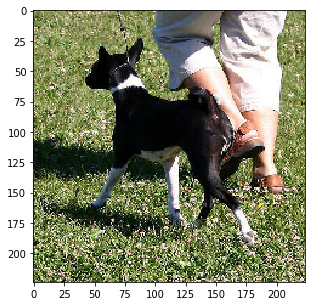

In [16]:
img_id = labels_pivot['id'][0]
img = read_img(img_id, 'train', (224, 224))
print(img.shape)
plt.imshow(img.astype('uint8'))
plt.show()

### 使用keras预训练的ResNet50来进行分类

源代码：https://github.com/keras-team/keras/blob/master/keras/applications/resnet50.py

keras官方文档：https://keras-cn.readthedocs.io/en/latest/other/application/

```python
def ResNet50(include_top=True, weights='imagenet',
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format='channels_last'` in your Keras config
    at ~/.keras/keras.json. ### 这里是因为keras的后端既有tensorflow又有theano,对于图像数据的表示不一致。
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.　
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 197.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
```

- include_top:是否包含最后一层的全连接层，显然我们这儿是不包括的，因为分类只有１６类，而不是imageNet的1000类。
- weights: 'None'表示随机初始化的权重，'imagenet'表示在ImageNet上预训练得到的。也可以是其他预训练的权重文件路劲。
- input_tensor: 可选的Keras张量（即`layers.Input()`的输出）用作模型的图像输入。
- input_shape:如果是tensorflow则为(224,224,3)

```python
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

model = ResNet50(include_top=False, weights='imagenet')
```

在网上下载好预训练的[模型](https://storage.googleapis.com/kaggle-datasets/2798/7251/keras-pretrained-models.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1520930364&Signature=FJfxGDpPWgPphI0S8RMYC7rJam6rVcYZeG6OVanCyYnOea%2BV6WpiQ33BKd3ieGWO7p5k10n5UfTxlpabPRkNprOjvm6ADC%2BPMtwGYqsXiFxZLTmm21IHckw4pVRJf45ywezIZXNDPkpLCMP6s7b5%2FqRYg%2FHvfA8%2FA19xRGsmAaL0A%2F199Ump1qCzNqzi0J7sVZ8FK36%2Bt211vixCFGFocseTcUHv%2FW1xOiC61QvbpL%2Bsb82TkXVbh8avqaz8a8pBn2zAjFCh%2FdiksaFXvmVPjHp3ETtJwN%2FrwfOpXYnMmH%2FEHvyFVmG3SF50Cxd3xwrAJgyCeYDAunrDfxmfXN5ovQ%3D%3D)

In [17]:
!ls ./keras-pretrained-models

imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Kuszma.JPG
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


复制到~/.keras/models下，不然使用load_model时就会出现No model found in config file的情况

In [18]:
!cp ./keras-pretrained-models/*notop* ~/.keras/models/
!cp ./keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp ./keras-pretrained-models/resnet50* ~/.keras/models/

In [19]:
!ls /home/panxie/.keras/models/

imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


这里我们已经将预训练好的模型下载下来了。直接调用h5文件。

In [20]:
model = ResNet50(weights='imagenet')
config = model.get_config()
weights = model.get_weights()

In [21]:
print(config['name'])
print(weights[0].shape) # ResNet50第一个卷积核

resnet50
(7, 7, 3, 64)


```python
def decode_predictions(preds, top=5):
    """Decodes the prediction of an ImageNet model.
    # Arguments
        preds: Numpy tensor encoding a batch of predictions.
        top: Integer, how many top-guesses to return.
    # Returns
        A list of lists of top class prediction tuples
        `(class_name, class_description, score)`.
        One list of tuples per sample in batch input.
    # Raises
        ValueError: In case of invalid shape of the `pred` array
            (must be 2D).
    """
```

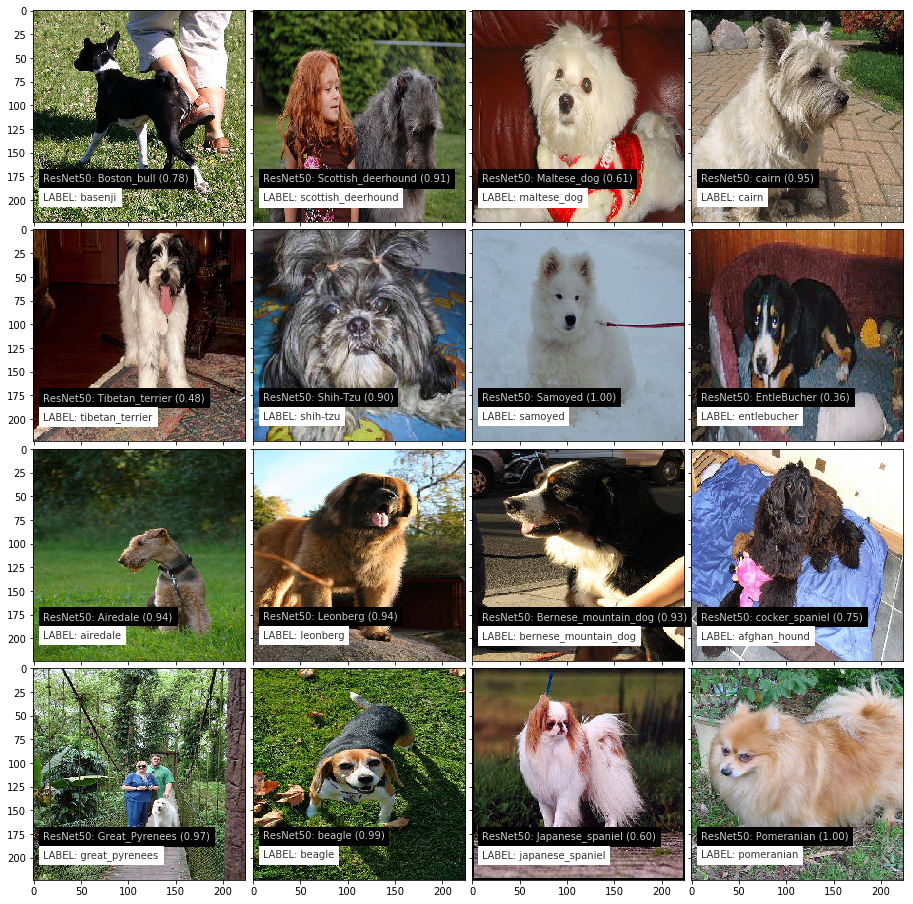

In [58]:
j = int(np.sqrt(NUM_CLASSES))
i = int(np.ceil(1*NUM_CLASSES/j)) # i行，ｊ列
# 每一类选出rank=1，即第一张图片，并显示出来
fig = plt.figure(1,(16,16))
grid = ImageGrid(fig, 111, (i,j), axes_pad=0.1)
for i, (img_id, breed) in enumerate(labels.loc[labels['rank']==1,['id','breed']].values):
    img = read_img(img_id, 'train',(224,224))  # 读取图片，并转换为ndarray (224,224,3)
    grid[i].imshow(img/255.)
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    #assert(pred.shape==(1,1000))
    preds = decode_predictions(preds, top=1)
    _, class_name, pred = preds[0][0]
    grid[i].text(10, 180, 'ResNet50: %s (%.2f)' % (class_name , pred), color='w', backgroundcolor='k', alpha=0.8)
    grid[i].text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
plt.show()

(500, 463, 3)
(224, 224, 3)


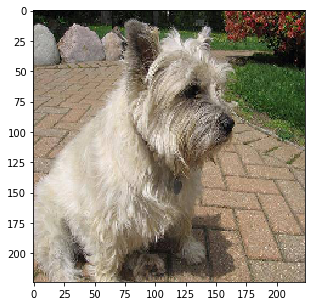

In [44]:
img_id1 = labels_pivot['id'][3]
img2 = image.load_img(os.path.join(base_dir, 'train', "%s.jpg"%img_id))
print(image.img_to_array(img2).shape)
img1 = read_img(img_id1, 'train', (224, 224))
print(img1.shape)
plt.imshow(img1.astype('uint8'))
plt.show()

In [24]:
xx = np.expand_dims(img1, axis=0)
assert(xx.shape==(1,224,224,3))
xx = preprocess_input(xx)
print(xx.shape)
y_preds = model.predict(xx)
y_preds = decode_predictions(y_preds, top=1)
print(y_preds)

(1, 224, 224, 3)
[[('n02112018', 'Pomeranian', 0.99850851)]]


(224, 224, 3)


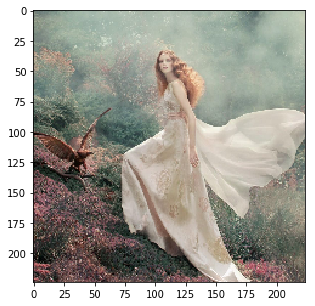

(1, 224, 224, 3)
[[('n03450230', 'gown', 0.68335193), ('n10148035', 'groom', 0.10732948), ('n03866082', 'overskirt', 0.10026653), ('n03534580', 'hoopskirt', 0.04028162)]]


In [59]:
image_dir = '/home/panxie/Documents/kaggle_dog_breed/webwxgeticon.jpeg'
img2 = image.load_img(image_dir,target_size=(224,224))
img2 = image.img_to_array(img2)
print(img2.shape)
plt.imshow(img2.astype('uint8'))
plt.show()
xxx = np.expand_dims(img2, axis=0)
xxx = preprocess_input(xxx)
print(xxx.shape)
y_preds = model.predict(xxx)
y_preds = decode_predictions(y_preds, top=4)
print(y_preds)

In [11]:
import os
imgs = os.listdir('test')[:10]
print(imgs)
imgs[0].split(".")[-2]

['53b689d150cded9b764db12339352284.jpg', '339eaf551663468edb3201703045e009.jpg', '7117c45cf0b7a127713028d41fcc7718.jpg', '661ee780fb4fbe4fe48a1e5765386dad.jpg', 'a6b8e7d61dbc98ba3ddca1accf4ac86a.jpg', 'a348eabfbbdc91423f1a8009f01fd16c.jpg', '981cd705b3b27b2cad68380e0e5f3d07.jpg', '57d6ca806ec02f9e8976b2f8fb5cf572.jpg', 'c7e902030813608c830629729601fe71.jpg', '2afc19a2977ea96c823cc86046dc7646.jpg']


'53b689d150cded9b764db12339352284'

In [8]:
imgs = sorted(imgs, key=lambda x: (x.split('.')[-2]))
print(imgs)

['2afc19a2977ea96c823cc86046dc7646.jpg', '339eaf551663468edb3201703045e009.jpg', '53b689d150cded9b764db12339352284.jpg', '57d6ca806ec02f9e8976b2f8fb5cf572.jpg', '661ee780fb4fbe4fe48a1e5765386dad.jpg', '7117c45cf0b7a127713028d41fcc7718.jpg', '981cd705b3b27b2cad68380e0e5f3d07.jpg', 'a348eabfbbdc91423f1a8009f01fd16c.jpg', 'a6b8e7d61dbc98ba3ddca1accf4ac86a.jpg', 'c7e902030813608c830629729601fe71.jpg']


In [12]:
from torchvision import transforms as T

In [20]:
from PIL import  Image
img = Image.open(os.path.join('test',imgs[0]))
transorm = T.ToTensor()
transorm(img)


( 0 ,.,.) = 
  0.4000  0.4235  0.4275  ...   0.2784  0.3098  0.4941
  0.4196  0.4078  0.4000  ...   0.2706  0.2980  0.4745
  0.3412  0.3961  0.4353  ...   0.2353  0.2667  0.4471
           ...             ⋱             ...          
  0.3098  0.3882  0.3843  ...   0.4549  0.4902  0.4824
  0.3725  0.3882  0.3961  ...   0.4196  0.5020  0.5255
  0.3686  0.3569  0.4078  ...   0.4118  0.5608  0.6431

( 1 ,.,.) = 
  0.4431  0.4667  0.4784  ...   0.3412  0.3725  0.5569
  0.4627  0.4588  0.4471  ...   0.3333  0.3608  0.5373
  0.3922  0.4471  0.4824  ...   0.2902  0.3216  0.5020
           ...             ⋱             ...          
  0.4275  0.5059  0.5020  ...   0.5216  0.5569  0.5490
  0.4902  0.5059  0.5137  ...   0.4863  0.5686  0.5922
  0.4863  0.4745  0.5255  ...   0.4784  0.6275  0.7098

( 2 ,.,.) = 
  0.1333  0.1569  0.1686  ...   0.1490  0.1804  0.3647
  0.1529  0.1451  0.1490  ...   0.1412  0.1686  0.3451
  0.0784  0.1373  0.1843  ...   0.0980  0.1294  0.3098
           ...         

In [65]:
import os
import pandas as pd

print(len(os.listdir('data/test')))
print(len(os.listdir('data/train')))
labels = pd.read_csv('data/labels.csv')
print(labels.shape)
print(labels[:5])

10357
10222
(10222, 2)
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [66]:
root = 'data/'
imgs = [os.path.join(root,'train', img) for img in os.listdir(os.path.join(root, 'train'))]

imgs = sorted(imgs, key=lambda x: (x.split('.')[-2])) # 将图片按id进行排序
imgs_num = len(imgs)
print(imgs_num)

10222


In [67]:

labels = pd.read_csv(os.path.join(root, 'labels.csv'))
labels['target'] = 1
labels_pivot = labels.pivot('id', 'breed', 'target')
labels = labels_pivot.reset_index().fillna(0)
print(labels[:2])

breed                                id  affenpinscher  afghan_hound  \
0      000bec180eb18c7604dcecc8fe0dba07            0.0           0.0   
1      001513dfcb2ffafc82cccf4d8bbaba97            0.0           0.0   

breed  african_hunting_dog  airedale  american_staffordshire_terrier  \
0                      0.0       0.0                             0.0   
1                      0.0       0.0                             0.0   

breed  appenzeller  australian_terrier  basenji  basset        ...          \
0              0.0                 0.0      0.0     0.0        ...           
1              0.0                 0.0      0.0     0.0        ...           

breed  toy_poodle  toy_terrier  vizsla  walker_hound  weimaraner  \
0             0.0          0.0     0.0           0.0         0.0   
1             0.0          0.0     0.0           0.0         0.0   

breed  welsh_springer_spaniel  west_highland_white_terrier  whippet  \
0                         0.0                          

In [68]:
print(imgs[:5])
print('\n')
labels_ = labels.drop('id',axis=1, inplace=False)
print(labels_.values)

['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg', 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg', 'data/train/001cdf01b096e06d78e9e5112d419397.jpg', 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg', 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [72]:
print(labels_.values.argmax(axis=1))

[19 37 85 ...,  3 75 28]


In [30]:
import numpy as np
mask = list(np.random.randint(0,imgs_num,(int(0.7*imgs_num))))
print(mask[:10])

[4041, 1863, 6175, 1427, 7728, 489, 8962, 7588, 8524, 2105]
